## Imports


In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

import os
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

## Read in Data


In [3]:
app_train = pd.read_csv('input/application_train.csv')
print('Taille des données d\'entraînement : ', app_train.shape)
app_train.head()


Taille des données d'entraînement :  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
app_test = pd.read_csv('input/application_test.csv')
print('Taille des données de test : ', app_test.shape)
app_test.head()


Taille des données de test :  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Exploration et Analyse des donnees


## Distribution de la cible (TARGET)


In [5]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

<Axes: xlabel='TARGET', ylabel='Count'>

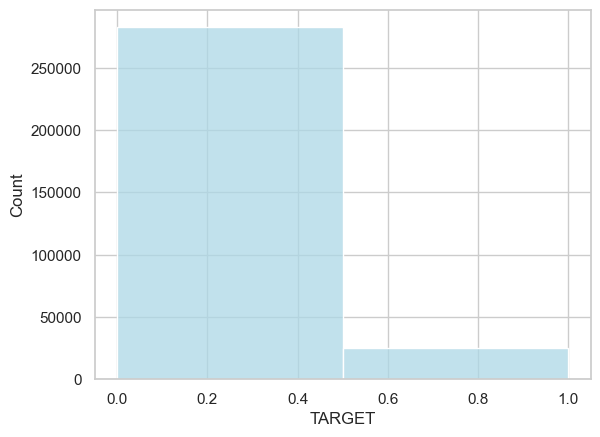

In [6]:
sns.set(style="whitegrid")
sns.histplot(app_train['TARGET'].astype(int), bins=2, kde=False, color='lightblue')



Cet histogramme montre la distribution des valeurs de la colonne 'TARGET'.
On peut observer que la majorité des prêts sont remboursés (0) alors qu'une petite proportion n'est pas remboursée (1).

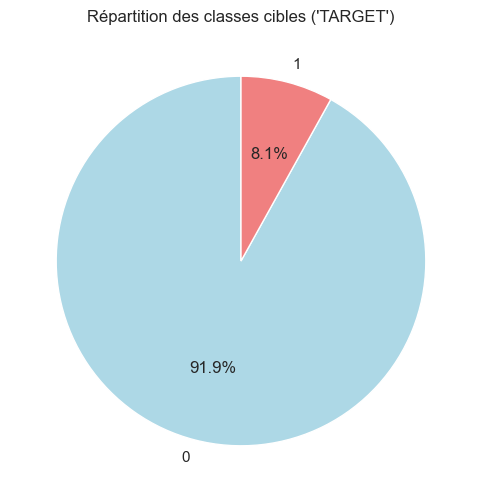

In [7]:
target_counts = app_train['TARGET'].value_counts()

plt.figure(figsize=(6, 6))
target_counts = app_train['TARGET'].value_counts()
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title("Répartition des classes cibles ('TARGET')")
plt.show()

Ce camembert montre la répartition des cibles 'TARGET'. On voit que 91,9% des clients remboursent leur prêt (0),
alors que 8,1% des clients ne remboursent pas leur prêt (1).

## Valeurs Manquantes


In [8]:
# Fonction pour calculer les valeurs manquantes par colonne
def missing_values_table(df):
    """
    Cette fonction calcule le nombre total et le pourcentage
    des valeurs manquantes dans chaque colonne du DataFrame.
    """

    mis_val = df.isnull().sum()

    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Valeurs Manquantes', 1: '% du Total des Valeurs'}
    )

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% du Total des Valeurs', ascending=False).round(1)

    print(f"Le DataFrame contient {df.shape[1]} colonnes.\n"
          f"Il y a {mis_val_table_ren_columns.shape[0]} colonnes avec des valeurs manquantes.")

    return mis_val_table_ren_columns

missing_values = missing_values_table(app_train)

missing_values.head()


Le DataFrame contient 122 colonnes.
Il y a 67 colonnes avec des valeurs manquantes.


,Valeurs Manquantes,% du Total des Valeurs
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4


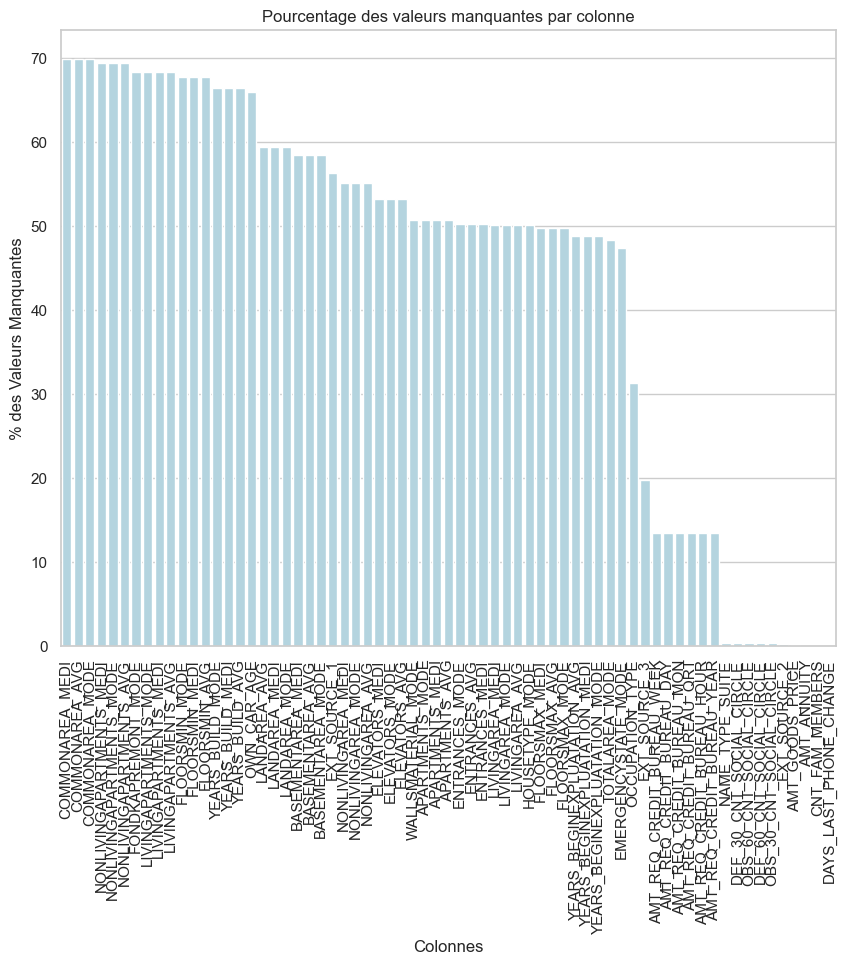

In [9]:
plt.figure(figsize=(10, 8))
sns.barplot(x=missing_values.index, y=missing_values['% du Total des Valeurs'], palette=['lightblue'])

plt.xticks(rotation=90)
plt.ylabel('% des Valeurs Manquantes')
plt.xlabel('Colonnes')
plt.title('Pourcentage des valeurs manquantes par colonne')

plt.show()

In [10]:

# Definition d'un seuil à 60% pour supprimer les colonnes
threshold = 60.0

columns_to_drop = missing_values[missing_values['% du Total des Valeurs'] > threshold].index

print(f"Colonnes à supprimer car elles ont plus de {threshold}% de valeurs manquantes:\n", columns_to_drop)

app_train = app_train.drop(columns=columns_to_drop)

# Afficher la forme du DataFrame après la suppression des colonnes
print("Nouvelle forme du DataFrame après suppression:", app_train.shape)

Colonnes à supprimer car elles ont plus de 60.0% de valeurs manquantes:
 Index(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI',
       'FLOORSMIN_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE'],
      dtype='object')
Nouvelle forme du DataFrame après suppression: (307511, 105)


## Type des colonnes



In [11]:
# Nombre de chaque type de colonne
app_train.dtypes.value_counts()

float64    49
int64      41
object     15
Name: count, dtype: int64

In [12]:
# Nombre de classes uniques dans chaque colonne de type 'object'
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Encoder les variables categorielles



### Label Encoding et One-Hot Encoding



In [13]:


# Fixer un seuil pour définir les catégories rares
rare_threshold = 0.01

# Fonction pour traiter les catégories rares dans les colonnes catégorielles
def handle_rare_categories(df, threshold):
    """
    Remplace les catégories rares dans les colonnes catégorielles par 'Other'.
    """
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    for col in categorical_columns:
        # Calculer la fréquence de chaque catégorie
        freq = df[col].value_counts(normalize=True)
        
        # Identifier les catégories rares
        rare_categories = freq[freq < threshold].index
        
        # Remplacer les catégories rares par 'Other'
        df[col] = df[col].replace(rare_categories, 'Other')
    
    return df


app_train = handle_rare_categories(app_train, rare_threshold)
app_test = handle_rare_categories(app_test, rare_threshold)


le = LabelEncoder()
le_count = 0


for col in app_train:
    if app_train[col].dtype == 'object':
        combined = pd.concat([app_train[col], app_test[col]], axis=0)

        # Si la colonne a 2 catégories uniques ou moins, appliquer l'encodage de labels
        if len(combined.unique()) <= 2:
            le.fit(combined)
            
            # Appliquer l'encodage de labels sur les données d'entraînement et de test
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1



app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)


train_labels = app_train['TARGET']
app_train = app_train.drop(columns=['TARGET'])


app_train, app_test = app_train.align(app_test, join='inner', axis=1)


app_train['TARGET'] = train_labels


print('Dimensions des features d\'entraînement : ', app_train.shape)
print('Dimensions des features de test : ', app_test.shape)


sns.set_palette(['lightblue', 'lightcoral'])


Dimensions des features d'entraînement :  (307511, 165)
Dimensions des features de test :  (48744, 164)


## Anomalies




In [14]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [15]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

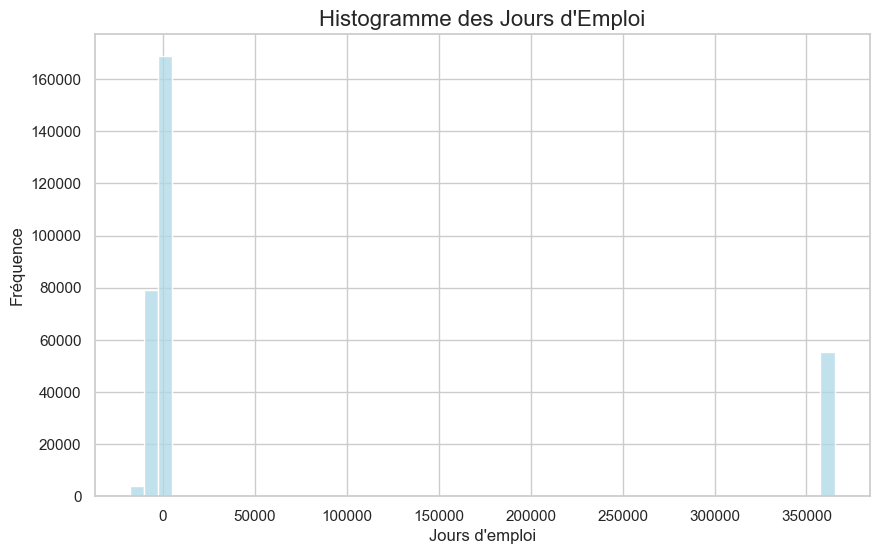

In [16]:
# Histogramme des jours d'emploi
plt.figure(figsize=(10, 6))
sns.histplot(app_train['DAYS_EMPLOYED'], bins=50, color='lightblue')


plt.title('Histogramme des Jours d\'Emploi', fontsize=16)
plt.xlabel('Jours d\'emploi', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)

# Affichage du graphique
plt.show()

Ce graphique montre la distribution des jours d'emploi dans le dataset. Une anomalie avec de très grandes valeurs est visible.

In [17]:
# Sélectionner les anomalies et non-anomalies basées sur la valeur de 'DAYS_EMPLOYED'
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

print("Les non-anomalies présentent un défaut de paiement dans {:.2f}% des prêts".format(100 * non_anom['TARGET'].mean()))
print("Les anomalies présentent un défaut de paiement dans {:.2f}% des prêts".format(100 * anom['TARGET'].mean()))
print("Il y a {} jours d'emploi anormaux".format(len(anom)))


Les non-anomalies présentent un défaut de paiement dans 8.66% des prêts
Les anomalies présentent un défaut de paiement dans 5.40% des prêts
Il y a 55374 jours d'emploi anormaux


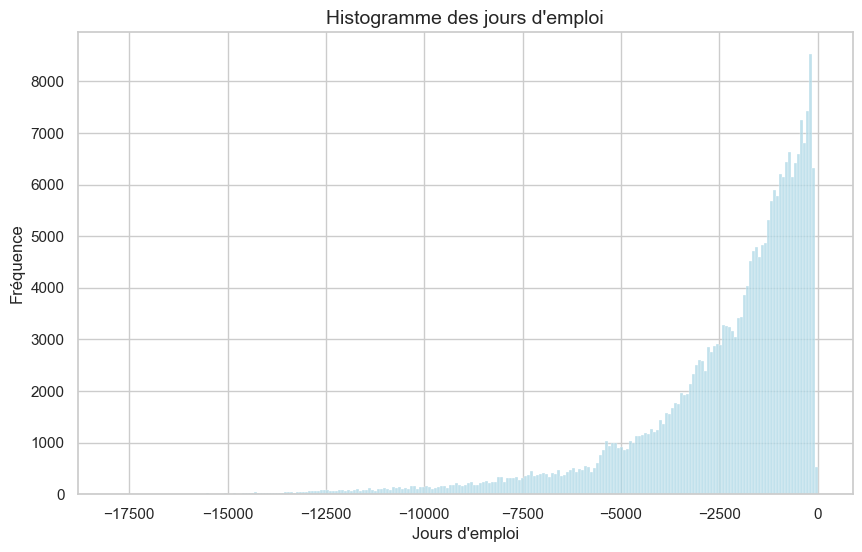

In [18]:
# colonne pour identifier les anomalies
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Remplacer les valeurs anormales par des NaN
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


plt.figure(figsize=(10, 6))
sns.histplot(app_train['DAYS_EMPLOYED'].dropna(), color='lightblue', kde=False)
plt.title("Histogramme des jours d'emploi", fontsize=14)
plt.xlabel("Jours d'emploi", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.show()



Le graphique montre une distribution très asymétrique des jours d'emploi, avec une concentration près de zéro.

In [19]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

# Remplacer les valeurs anormales par NaN
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


print('Il y a %d anomalies dans les données de test sur un total de %d entrées' % 
      (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))


Il y a 9274 anomalies dans les données de test sur un total de 48744 entrées


### Correlations
* .00-.19 “tres faible”
*  .20-.39 “faible”
*  .40-.59 “moderé”
*  .60-.79 “forte”
* .80-1.0 “tres forte”


In [20]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Corrélations les plus positives :\n', correlations.tail(15))
print('\nCorrélations les plus négatives :\n', correlations.head(15))



Corrélations les plus positives :
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Corré

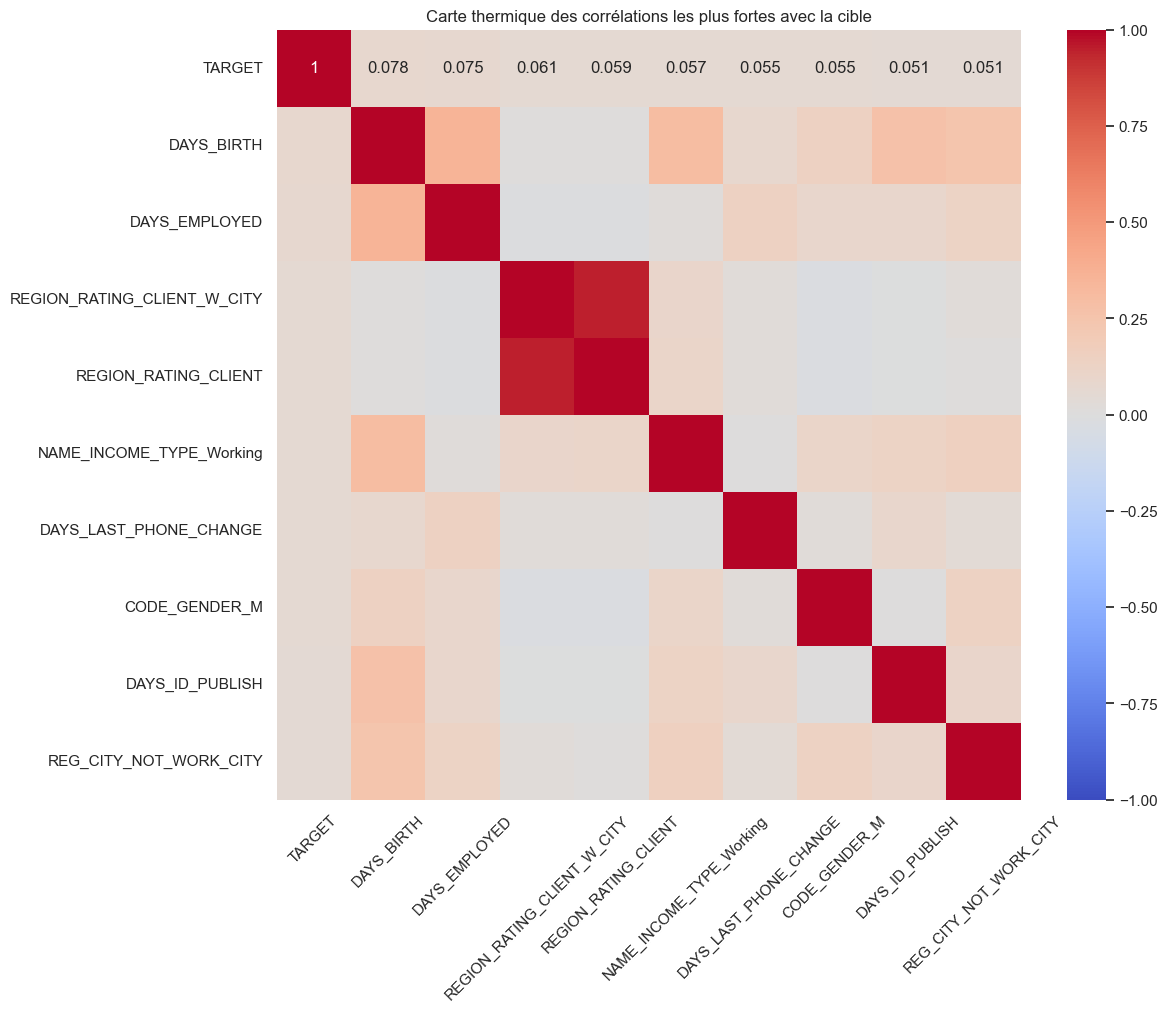

In [21]:
corr_matrix = app_train.corr()

# Sélection des 20 caractéristiques les plus corrélées avec la variable cible
top_corr_features = corr_matrix['TARGET'].nlargest(10).index

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.loc[top_corr_features, top_corr_features], annot=True, cmap='coolwarm', 
            xticklabels=1, yticklabels=1, vmin=-1, vmax=1)
plt.xticks(rotation=45)
plt.title("Carte thermique des corrélations les plus fortes avec la cible")
plt.show()


### Effect of Age on Repayment

In [22]:
# Calculer la corrélation entre les jours positifs depuis la naissance et la cible
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
correlation_days_birth = app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

print(f"La corrélation entre 'DAYS_BIRTH' et 'TARGET' est de {correlation_days_birth:.4f}")


La corrélation entre 'DAYS_BIRTH' et 'TARGET' est de -0.0782


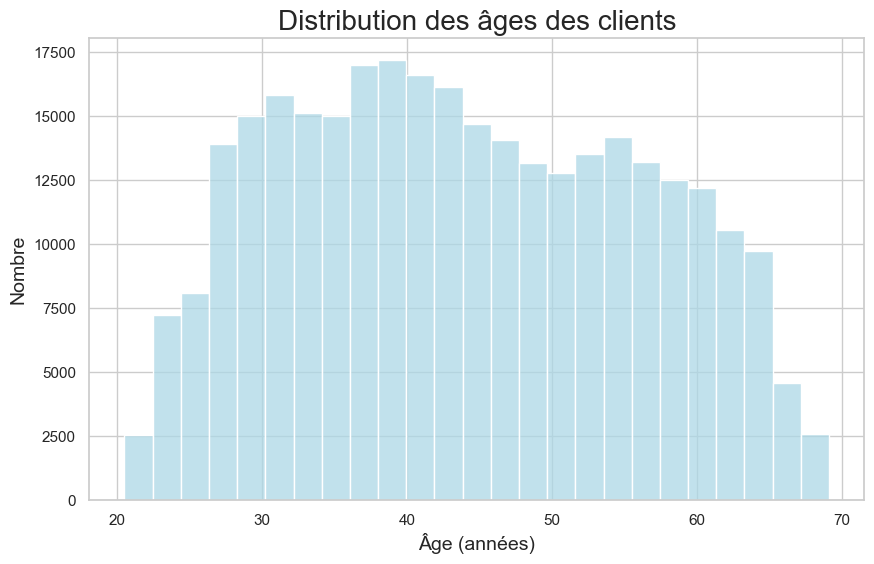

In [23]:
#  distribution des âges en années
plt.figure(figsize=(10, 6))
sns.histplot(app_train['DAYS_BIRTH'] / 365, bins=25, color='lightblue', kde=False)

plt.title('Distribution des âges des clients', size=20)
plt.xlabel('Âge (années)', size=14)
plt.ylabel('Nombre', size=14)

plt.show()


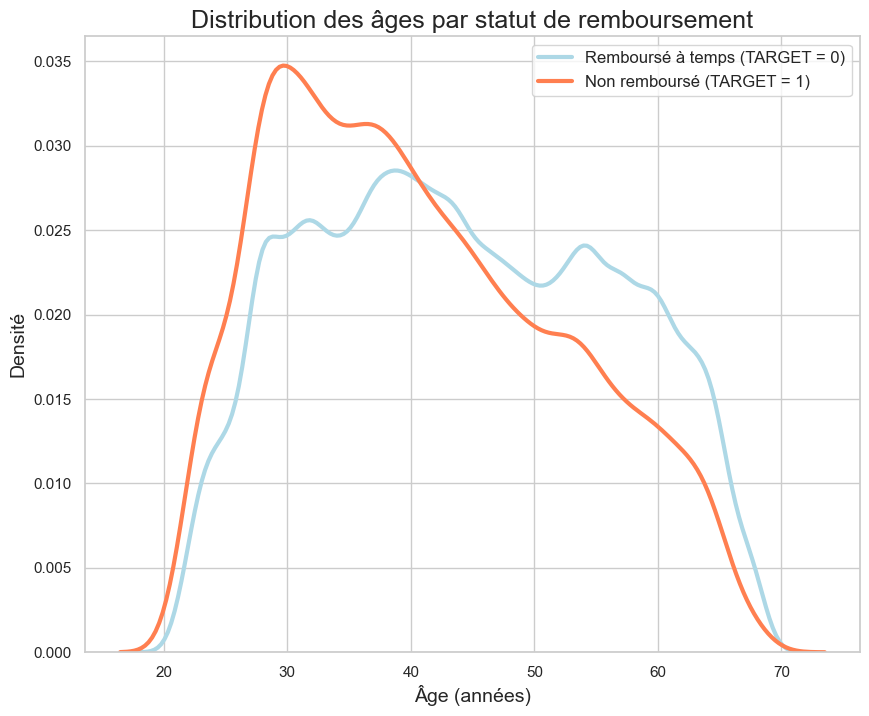

In [24]:
#  densité de prêts remboursés à temps et non remboursés

plt.figure(figsize=(10, 8))

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, 
            label="Remboursé à temps (TARGET = 0)", color="lightblue", linewidth=3)

sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, 
            label="Non remboursé (TARGET = 1)", color="coral", linewidth=3)

plt.xlabel('Âge (années)', size=14)
plt.ylabel('Densité', size=14)
plt.title('Distribution des âges par statut de remboursement', size=18)

plt.legend(['Remboursé à temps (TARGET = 0)', 'Non remboursé (TARGET = 1)'], fontsize=12)

plt.show()


Ce graphique montre la distribution des âges des clients en fonction du statut de remboursement des prêts. Les clients plus jeunes et plus âgés semblent avoir une plus forte proportion de prêts non remboursés (courbe rouge), tandis que les clients d'âge moyen tendent à mieux rembourser leurs prêts (courbe bleue).

In [25]:

age_data = app_train[['TARGET', 'DAYS_BIRTH']]


age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Catégorisation des données d'âge en intervalles (binning)
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11))

age_data.head(10)


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [26]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups


,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


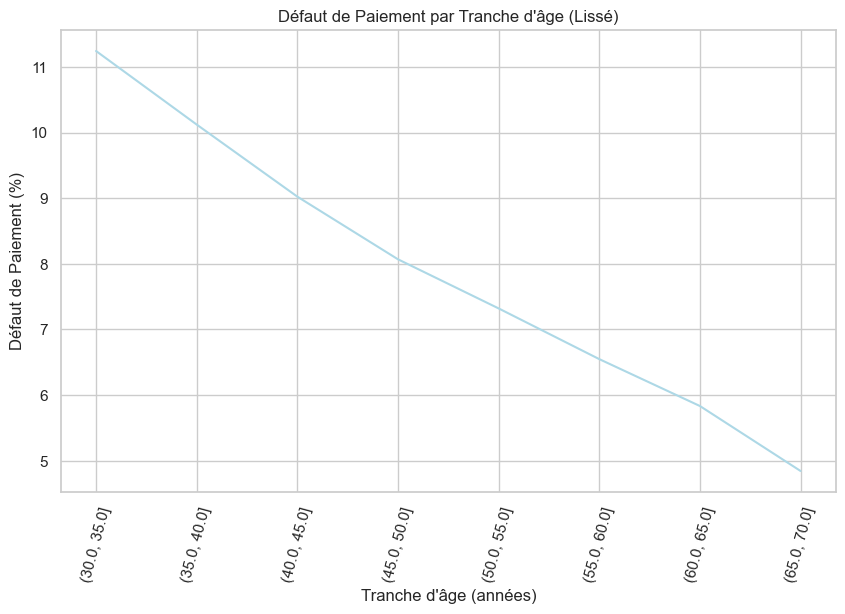

In [27]:
age_groups['TARGET_ROLLING_AVG'] = age_groups['TARGET'].rolling(window=3).mean()

plt.figure(figsize=(10, 6))
plt.plot(age_groups.index.astype(str), 100 * age_groups['TARGET_ROLLING_AVG'], color='lightblue')
plt.xticks(rotation=75)
plt.xlabel('Tranche d\'âge (années)')
plt.ylabel('Défaut de Paiement (%)')
plt.title('Défaut de Paiement par Tranche d\'âge (Lissé)')

plt.show()


Le graphique montre une baisse régulière du taux de défaut de paiement à mesure que les groupes d'âge augmentent, indiquant que les personnes plus âgées sont moins susceptibles de faire défaut sur leurs prêts.

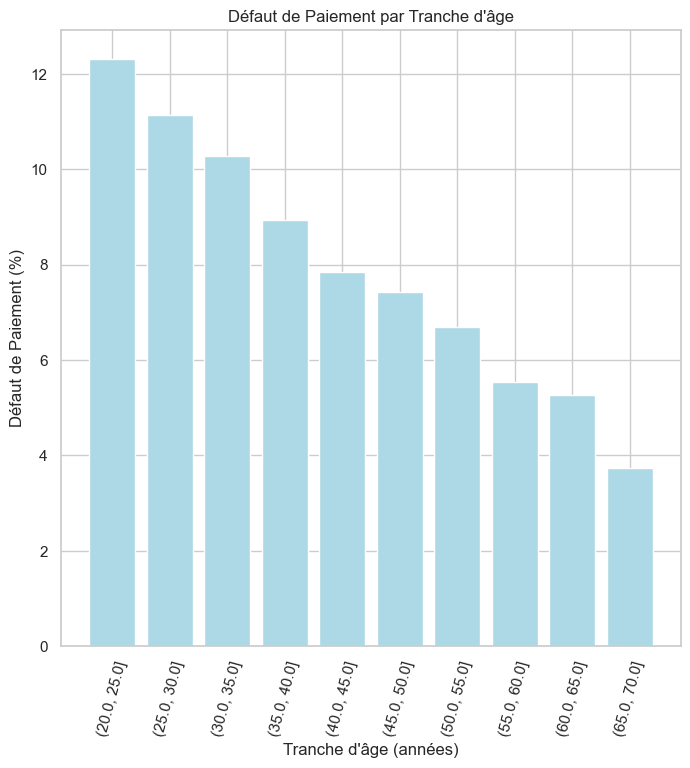

In [28]:
plt.figure(figsize=(8, 8))

# Graphe des tranches d'âge et la moyenne du taux de défaut
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'], color='lightblue')

# Étiquetage du graphique
plt.xticks(rotation=75)
plt.xlabel('Tranche d\'âge (années)')
plt.ylabel('Défaut de Paiement (%)')
plt.title('Défaut de Paiement par Tranche d\'âge')

plt.show()


## Genre

<Figure size 1000x600 with 0 Axes>

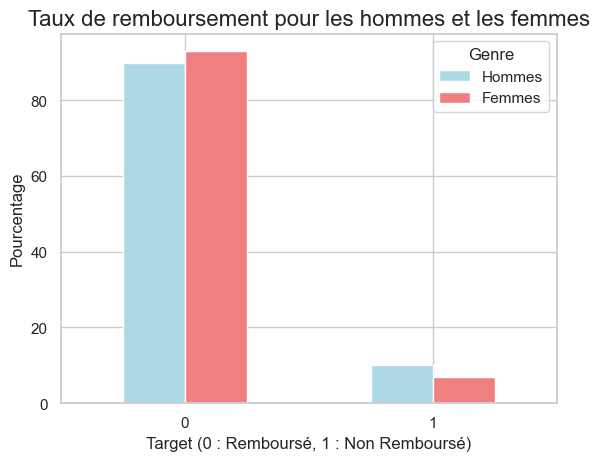

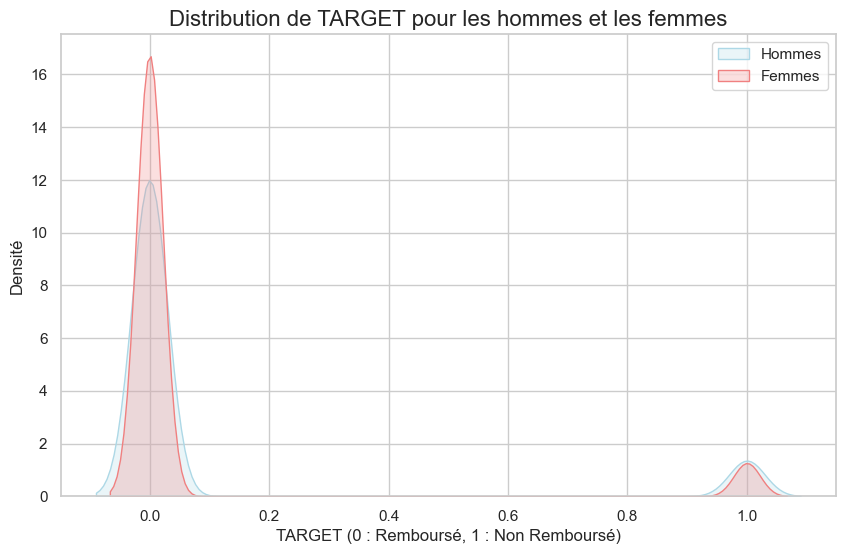

Taux de remboursement des hommes (en pourcentage du total) :
TARGET
0    89.85808
1    10.14192
dtype: float64

Taux de remboursement des femmes (en pourcentage du total) :
TARGET
0    93.000672
1     6.999328
dtype: float64


In [29]:
men_data = app_train[app_train['CODE_GENDER_M'] == 1]
women_data = app_train[app_train['CODE_GENDER_F'] == 1]
# taux de remboursement pour les hommes et les femmes
men_repayment_rate = men_data.groupby('TARGET').size() / len(men_data) * 100
women_repayment_rate = women_data.groupby('TARGET').size() / len(women_data) * 100


repayment_df = pd.DataFrame({
    'Hommes': men_repayment_rate,
    'Femmes': women_repayment_rate
})

plt.figure(figsize=(10, 6))
repayment_df.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title("Taux de remboursement pour les hommes et les femmes", fontsize=16)
plt.ylabel("Pourcentage", fontsize=12)
plt.xlabel("Target (0 : Remboursé, 1 : Non Remboursé)", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Genre")
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(men_data['TARGET'], label='Hommes', color='lightblue', shade=True)
sns.kdeplot(women_data['TARGET'], label='Femmes', color='lightcoral', shade=True)
plt.title("Distribution de TARGET pour les hommes et les femmes", fontsize=16)
plt.xlabel("TARGET (0 : Remboursé, 1 : Non Remboursé)", fontsize=12)
plt.ylabel("Densité", fontsize=12)
plt.legend()
plt.show()

print("Taux de remboursement des hommes (en pourcentage du total) :")
print(men_repayment_rate)
print("\nTaux de remboursement des femmes (en pourcentage du total) :")
print(women_repayment_rate)


### Source Externes



In [30]:
# Extraire les variables EXT_SOURCE et afficher les corrélations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

print(ext_data_corrs)


                TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000


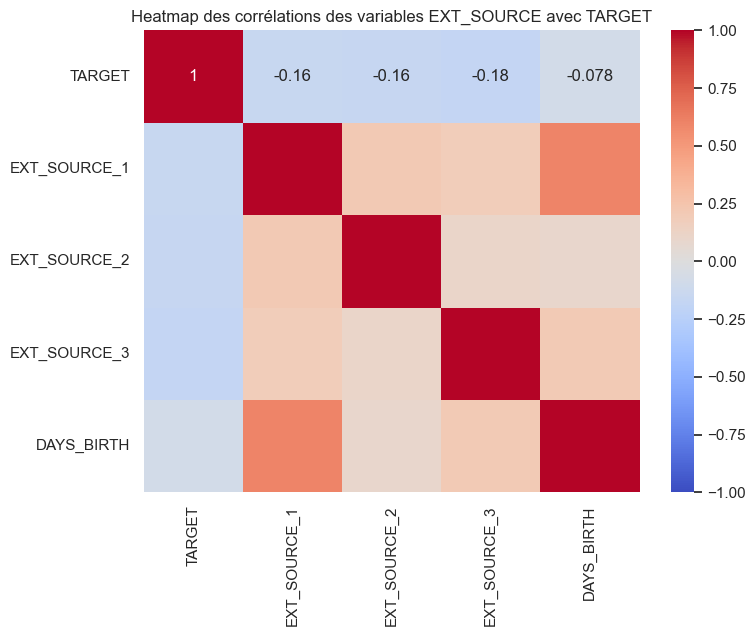

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(ext_data_corrs, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Heatmap des corrélations des variables EXT_SOURCE avec TARGET')
plt.show()

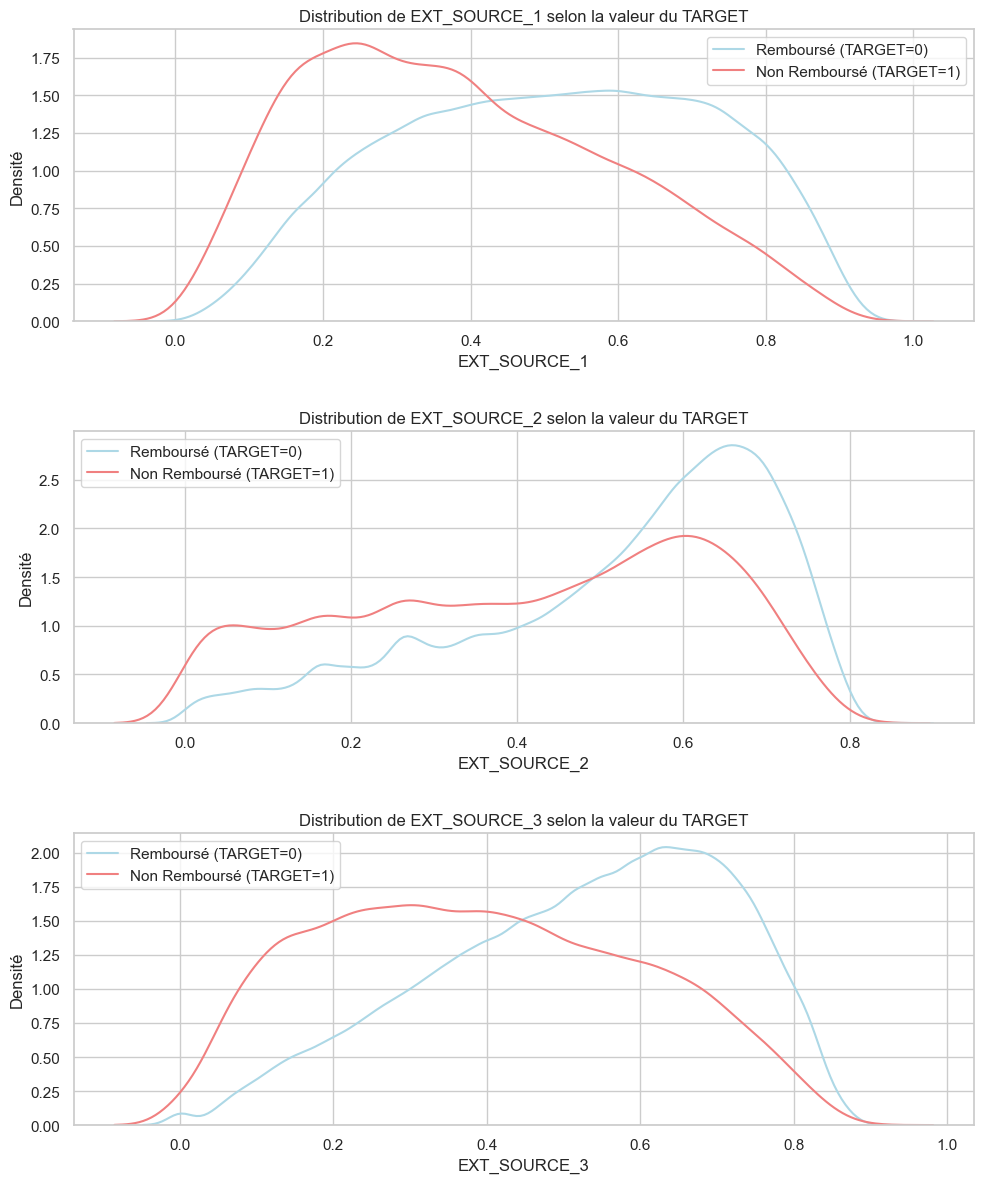

In [32]:
plt.figure(figsize=(10, 12))


for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i + 1)
    
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label='Remboursé (TARGET=0)', color='lightblue')
    
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label='Non Remboursé (TARGET=1)', color='lightcoral')
    
    plt.title(f'Distribution de {source} selon la valeur du TARGET')
    plt.xlabel(f'{source}')
    plt.ylabel('Densité')
    

    plt.legend()

plt.tight_layout(h_pad=2.5)
plt.show()

## Pairs Plot



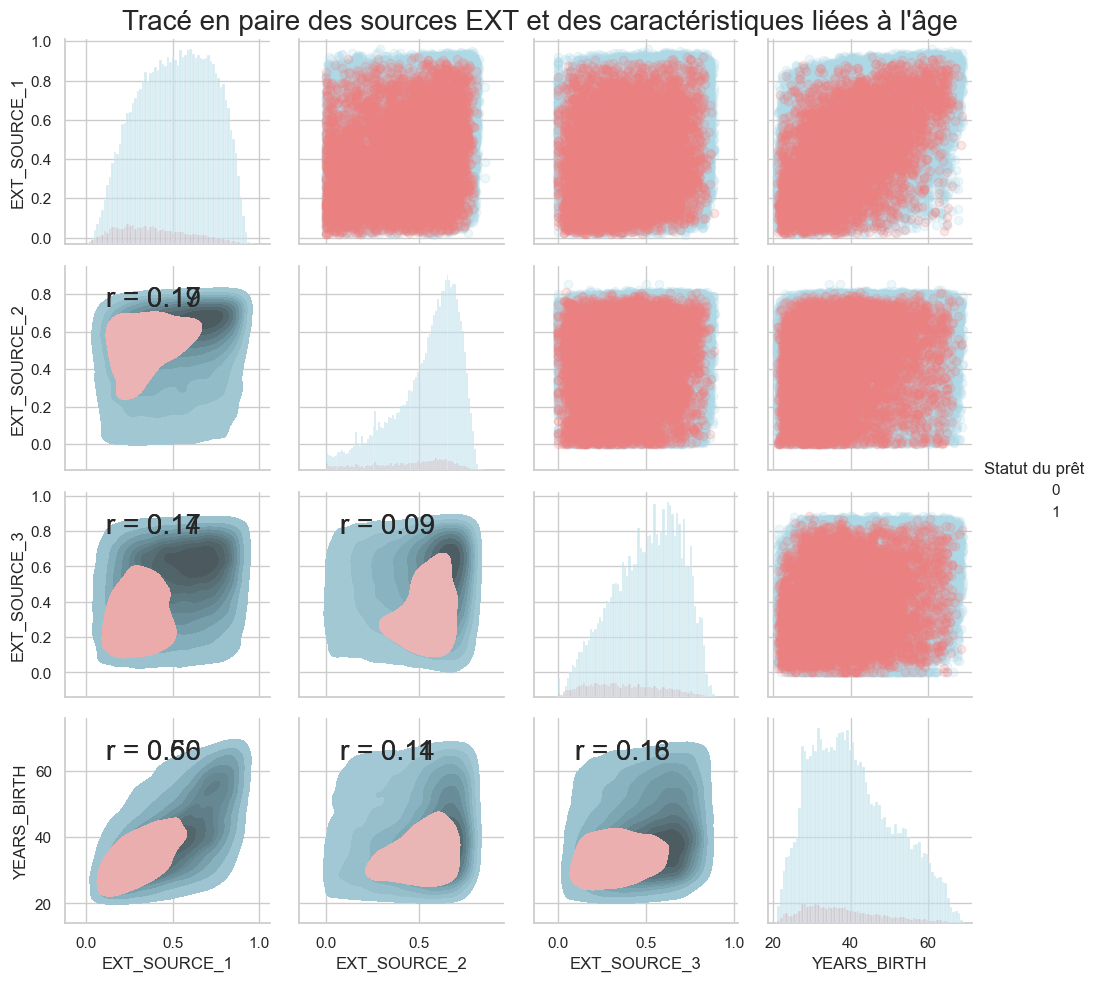

In [33]:

plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

plot_data = plot_data.dropna().iloc[:100000, :]


def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(.2, .8), xycoords=ax.transAxes, size=20)


grid = sns.PairGrid(data=plot_data, diag_sharey=False, hue='TARGET', palette={0: "lightblue", 1: "lightcoral"},
                    vars=[x for x in plot_data.columns if x != 'TARGET'])

grid.map_upper(plt.scatter, alpha=0.2)

grid.map_diag(sns.histplot, kde=False)

grid.map_lower(sns.kdeplot, cmap="coolwarm", shade=True)

grid.add_legend(title='Statut du prêt', label_order=[0, 1])

grid.map_lower(corr_func)

plt.subplots_adjust(top=0.95)
grid.fig.suptitle('Tracé en paire des sources EXT et des caractéristiques liées à l\'âge', size=20)

plt.show()


# Feature Engineering




In [34]:
corr_matrix = app_train.corr()

#Définir deux seuils un pour les fortes corrélations et un pour les faibles corrélations
strong_corr_threshold = 0.03   
low_corr_threshold = -0.03     

# fonctionnalités avec des corrélations au-dessus ou en dessous des seuils
strong_corr_features = corr_matrix['TARGET'][corr_matrix['TARGET'] >= strong_corr_threshold].index
low_corr_features = corr_matrix['TARGET'][corr_matrix['TARGET'] <= low_corr_threshold].index


selected_features = strong_corr_features.union(low_corr_features)

train_reduced = app_train[selected_features]
test_reduced = app_test[selected_features.drop('TARGET', errors='ignore')]

print(f"Nombre de fonctionnalités retenues : {len(selected_features)}")
print("Fonctionnalités retenues après application des seuils de corrélation (forte & faible) :")
for feature in selected_features:
    print(feature)
    

train_reduced['AMT_INCOME_TOTAL'] =  app_train['AMT_INCOME_TOTAL']
test_reduced['AMT_INCOME_TOTAL'] =  app_test['AMT_INCOME_TOTAL']

train_reduced['AMT_ANNUITY'] =  app_train['AMT_ANNUITY']
test_reduced['AMT_ANNUITY'] =  app_test['AMT_ANNUITY']



Nombre de fonctionnalités retenues : 45
Fonctionnalités retenues après application des seuils de corrélation (forte & faible) :
AMT_CREDIT
AMT_GOODS_PRICE
CODE_GENDER_F
CODE_GENDER_M
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_EMPLOYED_ANOM
DAYS_ID_PUBLISH
DAYS_LAST_PHONE_CHANGE
DAYS_REGISTRATION
DEF_30_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
ELEVATORS_AVG
ELEVATORS_MEDI
ELEVATORS_MODE
EMERGENCYSTATE_MODE_No
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
FLAG_DOCUMENT_3
FLAG_EMP_PHONE
FLOORSMAX_AVG
FLOORSMAX_MEDI
FLOORSMAX_MODE
HOUSETYPE_MODE_block of flats
LIVE_CITY_NOT_WORK_CITY
LIVINGAREA_AVG
LIVINGAREA_MEDI
LIVINGAREA_MODE
NAME_CONTRACT_TYPE_Cash loans
NAME_EDUCATION_TYPE_Higher education
NAME_EDUCATION_TYPE_Secondary / secondary special
NAME_INCOME_TYPE_Pensioner
NAME_INCOME_TYPE_Working
OCCUPATION_TYPE_Drivers
OCCUPATION_TYPE_Laborers
ORGANIZATION_TYPE_XNA
REGION_POPULATION_RELATIVE
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
TARGET
TOTALAREA_MODE


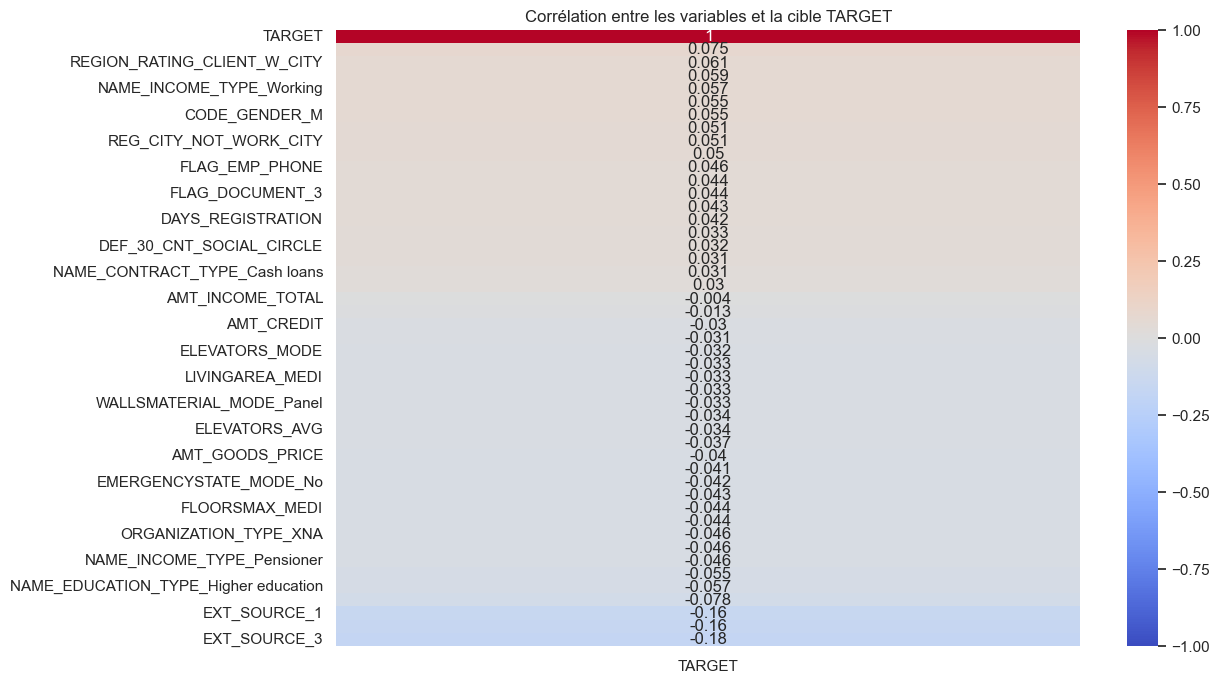

In [35]:
corr_matrix = train_reduced.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['TARGET']].sort_values(by='TARGET', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Corrélation entre les variables et la cible TARGET")
plt.show()


In [36]:
strong_corr_features

Index(['DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'NAME_CONTRACT_TYPE_Cash loans', 'CODE_GENDER_M',
       'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_Laborers', 'TARGET'],
      dtype='object')

In [37]:
low_corr_features

Index(['AMT_CREDIT', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'ELEVATORS_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'ELEVATORS_MODE',
       'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'ELEVATORS_MEDI', 'FLOORSMAX_MEDI',
       'LIVINGAREA_MEDI', 'TOTALAREA_MODE', 'CODE_GENDER_F',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_EDUCATION_TYPE_Higher education',
       'ORGANIZATION_TYPE_XNA', 'HOUSETYPE_MODE_block of flats',
       'WALLSMATERIAL_MODE_Panel', 'EMERGENCYSTATE_MODE_No',
       'DAYS_EMPLOYED_ANOM'],
      dtype='object')

## Simple Imputer

In [38]:
train_reduced.isna().sum()

AMT_CREDIT                                                0
AMT_GOODS_PRICE                                         278
CODE_GENDER_F                                             0
CODE_GENDER_M                                             0
DAYS_BIRTH                                                0
DAYS_EMPLOYED                                         55374
DAYS_EMPLOYED_ANOM                                        0
DAYS_ID_PUBLISH                                           0
DAYS_LAST_PHONE_CHANGE                                    1
DAYS_REGISTRATION                                         0
DEF_30_CNT_SOCIAL_CIRCLE                               1021
DEF_60_CNT_SOCIAL_CIRCLE                               1021
ELEVATORS_AVG                                        163891
ELEVATORS_MEDI                                       163891
ELEVATORS_MODE                                       163891
EMERGENCYSTATE_MODE_No                                    0
EXT_SOURCE_1                            

In [39]:
numeric_cols = train_reduced.select_dtypes(include=['float64', 'int64']).columns

numeric_imputer = SimpleImputer(strategy='median')

train_reduced[numeric_cols] = numeric_imputer.fit_transform(train_reduced[numeric_cols])

print(train_reduced.isna().sum())

AMT_CREDIT                                           0
AMT_GOODS_PRICE                                      0
CODE_GENDER_F                                        0
CODE_GENDER_M                                        0
DAYS_BIRTH                                           0
DAYS_EMPLOYED                                        0
DAYS_EMPLOYED_ANOM                                   0
DAYS_ID_PUBLISH                                      0
DAYS_LAST_PHONE_CHANGE                               0
DAYS_REGISTRATION                                    0
DEF_30_CNT_SOCIAL_CIRCLE                             0
DEF_60_CNT_SOCIAL_CIRCLE                             0
ELEVATORS_AVG                                        0
ELEVATORS_MEDI                                       0
ELEVATORS_MODE                                       0
EMERGENCYSTATE_MODE_No                               0
EXT_SOURCE_1                                         0
EXT_SOURCE_2                                         0
EXT_SOURCE

## Polynomial Features



TARGET                    1.000000
AGE_EXT_EXT_SOURCE_2      0.156873
AGE_EXT_EXT_SOURCE_3      0.150109
AGE_EXT_EXT_SOURCE_1      0.104882
AGE_YEARS                 0.078239
DAYS_EMPLOYED_PERCENT     0.049603
ANNUITY_INCOME_PERCENT    0.014268
CREDIT_TERM               0.012698
CREDIT_INCOME_RATIO      -0.007727
CREDIT_ANNUITY_RATIO     -0.032101
EXT_SOURCE_MEAN          -0.220840
Name: TARGET, dtype: float64


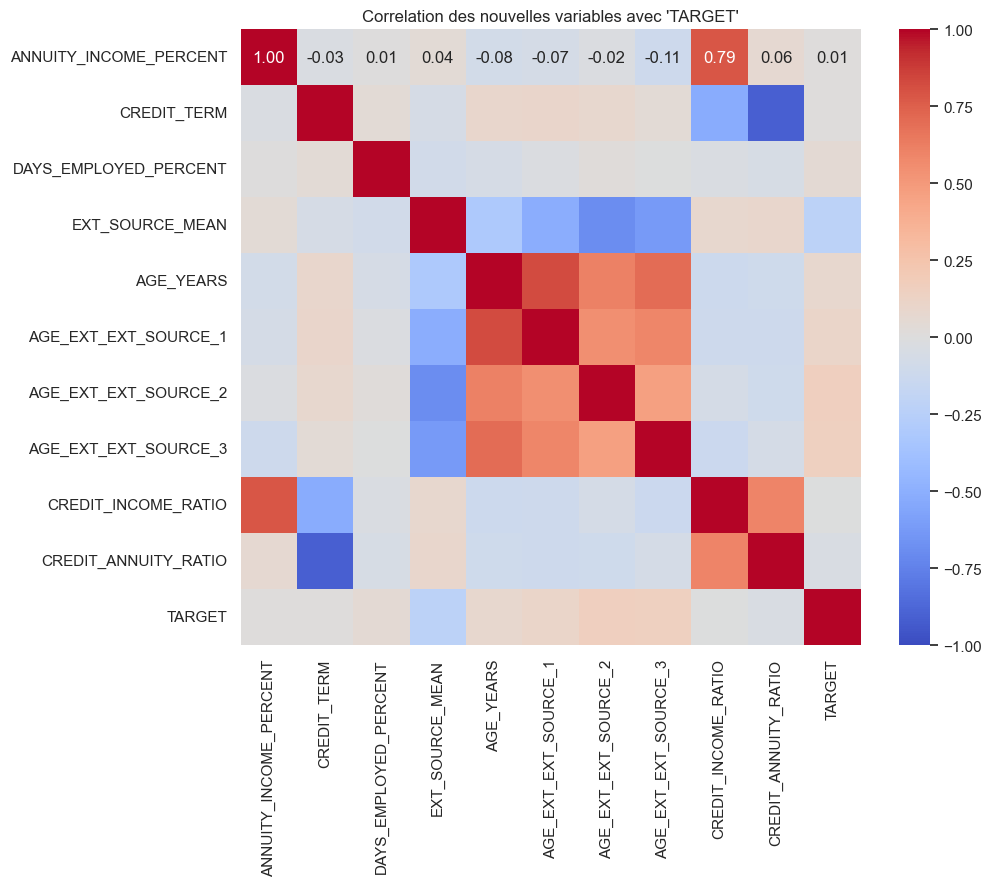

In [40]:
# pourcentage du prêt annuel par rapport au revenu total du client
train_reduced['ANNUITY_INCOME_PERCENT'] = train_reduced['AMT_ANNUITY'] / train_reduced['AMT_INCOME_TOTAL']
test_reduced['ANNUITY_INCOME_PERCENT'] = test_reduced['AMT_ANNUITY'] / test_reduced['AMT_INCOME_TOTAL']

# Durée du prêt 
train_reduced['CREDIT_TERM'] = train_reduced['AMT_ANNUITY'] / train_reduced['AMT_CREDIT']
test_reduced['CREDIT_TERM'] = test_reduced['AMT_ANNUITY'] / test_reduced['AMT_CREDIT']

# pourcentage des jours employés par rapport à l'âge du client
train_reduced['DAYS_EMPLOYED_PERCENT'] = train_reduced['DAYS_EMPLOYED'] / train_reduced['DAYS_BIRTH']
test_reduced['DAYS_EMPLOYED_PERCENT'] = test_reduced['DAYS_EMPLOYED'] / test_reduced['DAYS_BIRTH']

# Moyenne des variables EXT_SOURCE
train_reduced['EXT_SOURCE_MEAN'] = train_reduced[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
test_reduced['EXT_SOURCE_MEAN'] = test_reduced[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

# Création des variables polynomiales pour l'âge
train_reduced['AGE_YEARS'] = train_reduced['DAYS_BIRTH'] / -365
test_reduced['AGE_YEARS'] = test_reduced['DAYS_BIRTH'] / -365

# Interaction entre l'âge et EXT_SOURCE
for source in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
    train_reduced['AGE_EXT_' + source] = train_reduced['AGE_YEARS'] * train_reduced[source]
    test_reduced['AGE_EXT_' + source] = test_reduced['AGE_YEARS'] * test_reduced[source]

# Ratio crédit/revenu
train_reduced['CREDIT_INCOME_RATIO'] = train_reduced['AMT_CREDIT'] / train_reduced['AMT_INCOME_TOTAL']
test_reduced['CREDIT_INCOME_RATIO'] = test_reduced['AMT_CREDIT'] / test_reduced['AMT_INCOME_TOTAL']

# Ratio crédit/annuité
train_reduced['CREDIT_ANNUITY_RATIO'] = train_reduced['AMT_CREDIT'] / train_reduced['AMT_ANNUITY']
test_reduced['CREDIT_ANNUITY_RATIO'] = test_reduced['AMT_CREDIT'] / test_reduced['AMT_ANNUITY']

new_features = ['ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT', 'EXT_SOURCE_MEAN', 'AGE_YEARS',
                'AGE_EXT_EXT_SOURCE_1', 'AGE_EXT_EXT_SOURCE_2', 'AGE_EXT_EXT_SOURCE_3', 'CREDIT_INCOME_RATIO', 
                'CREDIT_ANNUITY_RATIO']

features_to_corr = new_features + ['TARGET']

corr_matrix = train_reduced[features_to_corr].corr()

target_corr = corr_matrix['TARGET'].sort_values(ascending=False)

print(target_corr)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation des nouvelles variables avec 'TARGET'")
plt.show()


Meilleures corrélations avec TARGET :
TARGET                                    1.000000
EXT_SOURCE_2 EXT_SOURCE_3                 0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3    0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH      0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3               0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2               0.172282
Name: TARGET, dtype: float64


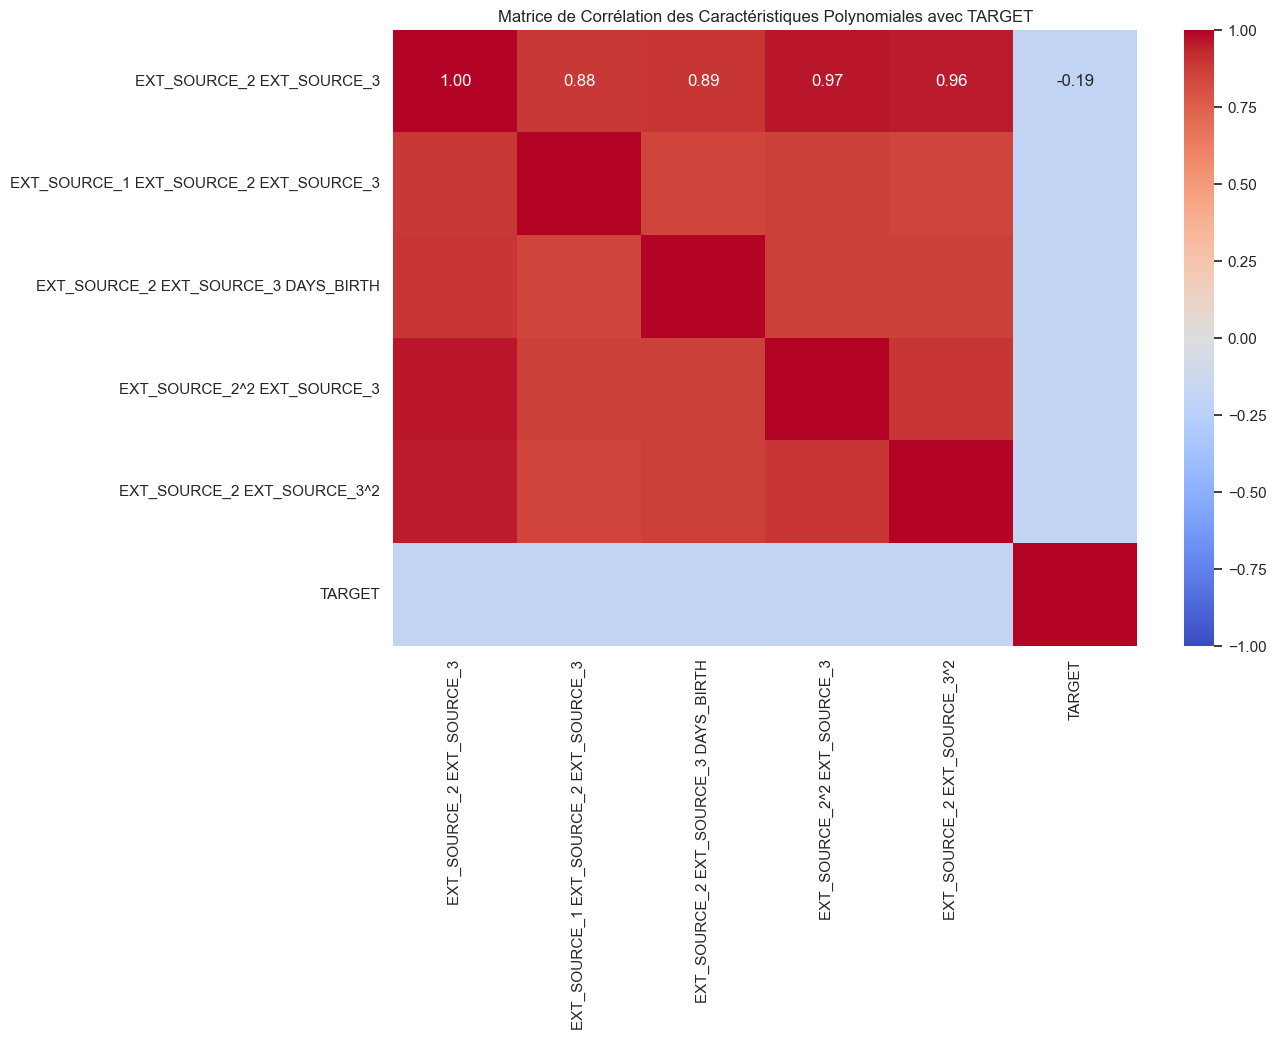

In [41]:
poly_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']

train_poly = train_reduced[poly_features].copy()
test_poly = test_reduced[poly_features].copy()

imputer = SimpleImputer(strategy="median")
train_poly = imputer.fit_transform(train_poly)
test_poly = imputer.transform(test_poly)

poly_transformer = PolynomialFeatures(degree=3)

train_poly_features = poly_transformer.fit_transform(train_poly)
test_poly_features = poly_transformer.transform(test_poly)

poly_feature_names = poly_transformer.get_feature_names_out(poly_features)

train_poly_df = pd.DataFrame(train_poly_features, columns=poly_feature_names)
test_poly_df = pd.DataFrame(test_poly_features, columns=poly_feature_names)

train_poly_df['TARGET'] = train_reduced['TARGET'].values

train_reduced_poly = pd.concat([train_reduced, train_poly_df], axis=1)
test_reduced_poly = pd.concat([test_reduced, test_poly_df], axis=1)

corr_matrix = train_poly_df.corr()

target_corr = corr_matrix['TARGET'].abs().sort_values(ascending=False)

top_5_features = target_corr.head(6).index.drop('TARGET')

train_df_top5 = train_poly_df[top_5_features]
test_df_top5 = test_poly_df[top_5_features]

train_reduced = pd.concat([train_reduced, train_df_top5], axis=1)
test_reduced = pd.concat([test_reduced, test_df_top5], axis=1)

features_to_corr = list(top_5_features) + ['TARGET']

corr_matrix = train_reduced[features_to_corr].corr()

target_corr = corr_matrix['TARGET'].abs().sort_values(ascending=False)
print("Meilleures corrélations avec TARGET :")
print(target_corr.head(10))

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice de Corrélation des Caractéristiques Polynomiales avec TARGET")
plt.show()


# Export CSV

In [42]:
train_reduced.shape

(307511, 62)

In [43]:
path="input/cleaned/"
filename = "df_cleaned.csv"

In [44]:
train_reduced.to_csv(path+filename, index=False)

In [45]:
all_features = train_reduced.columns
all_features

Index(['AMT_CREDIT', 'AMT_GOODS_PRICE', 'CODE_GENDER_F', 'CODE_GENDER_M',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_ANOM', 'DAYS_ID_PUBLISH',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'ELEVATORS_AVG',
       'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE_No',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_DOCUMENT_3',
       'FLAG_EMP_PHONE', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE',
       'HOUSETYPE_MODE_block of flats', 'LIVE_CITY_NOT_WORK_CITY',
       'LIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE',
       'NAME_CONTRACT_TYPE_Cash loans', 'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Working',
       'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_Laborers',
       'ORGANIZATION_TYPE_XNA', 'REGION_POPULATION_RELATIVE',
       'REGION_RATING_CLIENT', 'R

In [46]:
train_reduced['TARGET']

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
307506    0.0
307507    0.0
307508    0.0
307509    1.0
307510    0.0
Name: TARGET, Length: 307511, dtype: float64

In [47]:
train_reduced.isna().sum()

AMT_CREDIT                                0
AMT_GOODS_PRICE                           0
CODE_GENDER_F                             0
CODE_GENDER_M                             0
DAYS_BIRTH                                0
                                         ..
EXT_SOURCE_2 EXT_SOURCE_3                 0
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3    0
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH      0
EXT_SOURCE_2^2 EXT_SOURCE_3               0
EXT_SOURCE_2 EXT_SOURCE_3^2               0
Length: 62, dtype: int64